In [2]:
from __future__ import print_function

import pandas as pd 
import numpy as np 
import sklearn

# NLTK/NLP
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk import FreqDist, word_tokenize
import string, re
import urllib
from nltk.corpus import stopwords
from gensim.models import word2vec
from nltk.collocations import *
import gensim
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec


# Classifiers 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier  

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import scikitplot as skplt

#Sampling
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE

#Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# miscellaneous
from sklearn.utils import resample
import sklearn.decomposition as decomposition

import warnings 
warnings.filterwarnings("ignore")

import csv
import pickle

In [78]:
from src import *

In [77]:
# #run this when making local changes to the py file you want to impor
# %load_ext autoreload
# %autoreload 2

# %reload_ext autoreload

In [3]:
with open('data/cleaned-reshuffled.pkl', 'rb') as f:
	df = pickle.load(f)

In [4]:
df.head()

,id,label,tweet,tidy_tweet,no_hash_tweet,tokenized_tweet,stemmed_tokens,lemmatized_tokens,lem_tweet,stem_tweet
0,29727,0,sad to see the scenes of hooligans pre #engrus...,sad to see the scenes of hooligans pre #engrus...,sad to see the scenes of hooligans pre engrus ...,"[sad, to, see, the, scenes, of, hooligans, pre...","[sad, to, see, the, scene, of, hooligan, pre, ...","[sad, to, see, the, scene, of, hooligan, pre, ...",sad to see the scenes of hooligans pre engrus ...,sad to see the scenes of hooligans pre engrus ...
1,14466,0,#gooddyeyoung #yoyoyo !! super happy to be ap...,#gooddyeyoung #yoyoyo super happy to be apa of...,gooddyeyoung yoyoyo super happy to be apa of t...,"[gooddyeyoung, yoyoyo, super, happy, to, be, a...","[gooddyeyoung, yoyoyo, super, happi, to, be, a...","[gooddyeyoung, yoyoyo, super, happy, to, be, a...",gooddyeyoung yoyoyo super happy to be apa of t...,gooddyeyoung yoyoyo super happy to be apa of t...
2,18194,0,queen evil's bihdayð#lnic #lnicjustanevilbd...,queen evil s bihday #lnic #lnicjustanevilbday ...,queen evil s bihday lnic lnicjustanevilbday bi...,"[queen, evil, s, bihday, lnic, lnicjustanevilb...","[queen, evil, s, bihday, lnic, lnicjustanevilb...","[queen, evil, s, bihday, lnic, lnicjustanevilb...",queen evil s bihday lnic lnicjustanevilbday bi...,queen evil s bihday lnic lnicjustanevilbday bi...
3,18283,1,@user you might be a libtard if... #libtard #...,you might be a libtard if #libtard #sjw #liber...,you might be a libtard if libtard sjw liberal ...,"[you, might, be, a, libtard, if, libtard, sjw,...","[you, might, be, a, libtard, if, libtard, sjw,...","[you, might, be, a, libtard, if, libtard, sjw,...",you might be a libtard if libtard sjw liberal ...,you might be a libtard if libtard sjw liberal ...
4,25845,0,what are your goals? find out here... #smile...,what are your goals find out here #smile,what are your goals find out here smile,"[what, are, your, goals, find, out, here, smile]","[what, are, your, goal, find, out, here, smile]","[what, are, your, goal, find, out, here, smile]",what are your goals find out here smile,what are your goals find out here smil


## Train / Val / Test Split

In [5]:
X = df.drop(['label'], axis = 1)

In [6]:
y = df['label']

In [7]:
#splitting into train and test 
X_model, X_test, y_model, y_test = train_test_split(X, y, stratify = y, test_size=0.20, random_state=123)

In [8]:
#splitting "model" into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, stratify = y_model, test_size=0.20, random_state=123)

## Comparing Vectorization and Method Performance

In [145]:
#initializing vectorizers and creating tuple for wrapper comparison function

count_vect = CountVectorizer(1,1)
count_ngram1_2 = CountVectorizer(1,2)
count_ngram1_3 = CountVectorizer(1,3)

tfidf_vect = TfidfVectorizer(1,1)
tfidf_ngram1_2 = TfidfVectorizer(ngram_range=(1,2))
tfidf_ngram1_3 = TfidfVectorizer(ngram_range=(1,3))

vectorization_list = [('COUNT_VECTORIZER', count_vect),
                      ('COUNT_NGRAM_1_2', count_ngram1_2),
                      ('COUNT_NGRAM_1_3', count_ngram1_3),
                      ('TFIDF_VECTORIZER', tfidf_vect),
                      ('TFIDF_NGRAM_1_2', tfidf_ngram1_2),
                      ('TFIDF_NGRAM_1_3', tfidf_ngram1_3)]

# Multinomial Naive Bayes (MNB)

#### Initial Comparision: Multiple Vectorizer and Class Balance Corrections

In [75]:
np.random.seed(0)

In [76]:
#MNB with no class balance corrections
nb_results1 = compare_vectorization_model(X_train.lem_tweet, y_train, 
                                   X_val.lem_tweet, y_val, MultinomialNB(), vectorization_list)

nb_results1

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.97,0.97,0.97,0.94,0.94,0.94
Train F1,0.74,0.74,0.74,0.24,0.20,0.21
Train Precision,0.83,0.83,0.83,1.00,1.00,1.00
Train Recall,0.66,0.66,0.66,0.14,0.11,0.11
Validation Accuracy,0.96,0.96,0.96,0.94,0.94,0.94
Validation F1,0.60,0.60,0.60,0.20,0.17,0.18
Validation Precision,0.86,0.86,0.86,1.00,1.00,1.00
Validation Recall,0.46,0.46,0.46,0.11,0.09,0.10


In [77]:
nb_results1.to_csv('data/NB_results.csv', mode = 'a', header ='column_names')

In [78]:
#MNB with upsampling correction for class imbalance
nb_results3 = wrapper_compare_vectorizations(X_train.lem_tweet, y_train, 
                                   X_val.lem_tweet, y_val, MultinomialNB(), 
                                    vectorization_list, sampling = 'upsample')
nb_results3

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.97,0.97,0.97,0.97,0.99,0.99
Train F1,0.97,0.97,0.97,0.97,0.99,0.99
Train Precision,0.96,0.96,0.96,0.95,0.98,0.99
Train Recall,0.99,0.99,0.99,0.99,1.00,1.00
Validation Accuracy,0.92,0.92,0.92,0.90,0.90,0.90
Validation F1,0.57,0.57,0.57,0.53,0.55,0.53
Validation Precision,0.45,0.45,0.45,0.40,0.41,0.39
Validation Recall,0.79,0.79,0.79,0.81,0.82,0.84


In [79]:
nb_results3.to_csv('data/NB_results.csv', mode = 'a', header ='column_names')

In [80]:
#MNB with downsampling correction for class imbalance
nb_results4 = wrapper_compare_vectorizations(X_train.lem_tweet, y_train, 
                                   X_val.lem_tweet, y_val, MultinomialNB(), 
                                    vectorization_list, sampling = 'downsample')
nb_results4

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.97,0.97,0.97,0.97,0.99,1.00
Train F1,0.97,0.97,0.97,0.97,0.99,1.00
Train Precision,0.97,0.97,0.97,0.96,1.00,1.00
Train Recall,0.98,0.98,0.98,0.98,0.99,1.00
Validation Accuracy,0.84,0.84,0.84,0.83,0.83,0.83
Validation F1,0.44,0.44,0.44,0.43,0.42,0.42
Validation Precision,0.29,0.29,0.29,0.28,0.27,0.27
Validation Recall,0.89,0.89,0.89,0.89,0.87,0.90


In [81]:
nb_results4.to_csv('data/NB_results.csv', mode = 'a', header ='column_names')

In [82]:
#MNB with smote correction for class imbalance
nb_results5 = wrapper_compare_vectorizations(X_train.lem_tweet, y_train, 
                                   X_val.lem_tweet, y_val, MultinomialNB(), 
                                    vectorization_list, sampling = 'smote')
nb_results5

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.96,0.96,0.96,0.95,0.98,0.99
Train F1,0.76,0.76,0.76,0.73,0.86,0.91
Train Precision,0.68,0.68,0.68,0.58,0.75,0.84
Train Recall,0.85,0.85,0.85,0.99,1.00,1.00
Validation Accuracy,0.95,0.95,0.95,0.91,0.91,0.91
Validation F1,0.64,0.64,0.64,0.56,0.56,0.56
Validation Precision,0.60,0.60,0.60,0.42,0.43,0.42
Validation Recall,0.67,0.67,0.67,0.82,0.83,0.83


In [ ]:
nb_results5.to_csv('data/NB_results.csv', mode = 'a', header ='column_names')

### Fine Tuning Based on Best Performance with Count Vectorizer and SMOTE

In [439]:
np.random.seed(10)

nb = MultinomialNB()

parameters = {'alpha': [.001, .01, .1, .2, .3 , .4, .5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

scores = ['accuracy','recall','precision','f1']

nb_gs = GridSearchCV(nb, param_grid = parameters, 
                           verbose = 0, scoring = scores, cv = 3, refit = 'f1')

In [441]:
nb_1, nb_X_val1, nb_y_train_pred1, nb_y_val_pred1, \
                nb_y_val_prob1, nb_metrics1, nb_pred_df1 = \
wrapper_single_vectorization(X_train.lem_tweet, y_train, X_val.lem_tweet, 
                y_val, nb_gs, count_vect, sampling= 'smote')

In [442]:
nb_1.best_params_

{'alpha': 0.001}

In [443]:
nb_metrics1

{'Train Accuracy': 0.81,
 'Train Precision': 0.99,
 'Train Recall': 0.62,
 'Train F1': 0.76,
 'Validation Accuracy': 0.95,
 'Validation Precision': 0.65,
 'Validation Recall': 0.6,
 'Validation F1': 0.62}

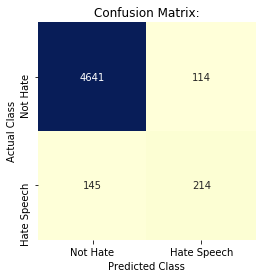

In [444]:
seaborn_confusion_matrix(y_val, nb_y_val_pred1)

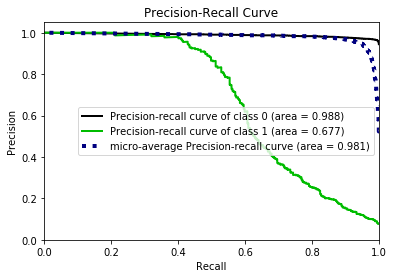

In [445]:
skplt.metrics.plot_precision_recall_curve(y_val, nb_y_val_prob1)

Adjusted Accuracy: 0.9546343371138052
Adjusted Precision: 0.7292418772563177
Adjusted Recall: 0.5626740947075209
Adjusted F1 Score: 0.6352201257861636




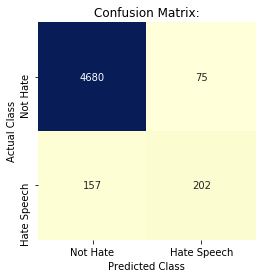

In [446]:
nb_adj_y_val, cm1 = adjust_threshold_and_score(y_val, nb_y_val_prob1, .2)

## Final Naive Bayes Model:  Performance on Test Set 

In [453]:
#use smote and count vectorizer based on validation process
nb_2, nb_X_test, nb_y_train_pred2, nb_y_test_pred, \
                nb_y_test_prob, nb_metrics2, nb_pred_df2 = \
wrapper_single_vectorization(X_model.lem_tweet, y_model, X_test.lem_tweet, 
                y_test, MultinomialNB(alpha = .001), count_vect, sampling= 'smote')

In [455]:
nb_metrics2

{'Train Accuracy': 0.84,
 'Train Precision': 0.99,
 'Train Recall': 0.69,
 'Train F1': 0.81,
 'Validation Accuracy': 0.96,
 'Validation Precision': 0.7,
 'Validation Recall': 0.65,
 'Validation F1': 0.67}

Adjusted Accuracy: 0.9601126231816048
Adjusted Precision: 0.7813411078717201
Adjusted Recall: 0.5982142857142857
Adjusted F1 Score: 0.6776232616940581




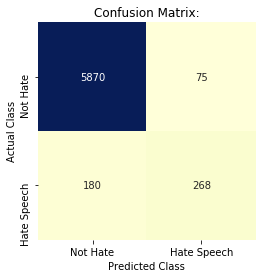

In [454]:
#final score based on adjusted threshold
nb_adj_y_test, nb_cm2 = adjust_threshold_and_score(y_test, nb_y_test_prob, .2)

# Logistic Regression

### Comparing multiple vectorization methods and sampling methods

In [146]:
#Logistic Regression: lemmatizing + no adjustments
lr_results1 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            LogisticRegression(solver = 'lbfgs', random_state = 10), 
                                            vectorization_list)

lr_results1

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.99,0.99,0.99,0.95,0.94,0.94
Train F1,0.89,0.89,0.89,0.43,0.29,0.22
Train Precision,0.99,0.99,0.99,0.97,0.99,0.99
Train Recall,0.80,0.80,0.80,0.28,0.17,0.12
Validation Accuracy,0.96,0.96,0.96,0.95,0.94,0.94
Validation F1,0.64,0.64,0.64,0.44,0.33,0.28
Validation Precision,0.85,0.85,0.85,0.92,0.91,0.88
Validation Recall,0.51,0.51,0.51,0.29,0.20,0.16


In [ ]:
lr_results1.to_csv('data/LR_results.csv',mode = 'a',header ='column_names')

In [11]:
#Logistic Regression: compare vectorizers using lemmitizing + class balances
lr_results2 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            LogisticRegression(class_weight= 'balanced', 
                            solver = 'lbfgs', random_state = 10), vectorization_list)
lr_results2

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.99,0.99,0.99,0.97,0.99,0.99
Train F1,0.93,0.93,0.93,0.81,0.91,0.96
Train Precision,0.87,0.87,0.87,0.68,0.84,0.92
Train Recall,0.99,0.99,0.99,0.99,1.00,1.00
Validation Accuracy,0.95,0.95,0.95,0.94,0.94,0.94
Validation F1,0.66,0.66,0.66,0.63,0.63,0.62
Validation Precision,0.62,0.62,0.62,0.53,0.55,0.54
Validation Recall,0.72,0.72,0.72,0.78,0.74,0.73


In [ ]:
lr_results2.to_csv('data/LR_results.csv',mode = 'a',header ='column_names')

In [13]:
#Logistic Regression: compare vectorizers using lemmitizing + upsampling
lr_results3 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            LogisticRegression(solver = 'lbfgs', 
                            random_state = 10), vectorization_list, sampling = 'upsample')
lr_results3

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.99,0.99,0.99,0.99,1.00,1.00
Train F1,0.99,0.99,0.99,0.99,1.00,1.00
Train Precision,0.99,0.99,0.99,0.97,0.99,1.00
Train Recall,1.00,1.00,1.00,1.00,1.00,1.00
Validation Accuracy,0.95,0.95,0.95,0.94,0.94,0.93
Validation F1,0.67,0.67,0.67,0.62,0.62,0.60
Validation Precision,0.63,0.63,0.63,0.53,0.54,0.50
Validation Recall,0.70,0.70,0.70,0.75,0.74,0.74


In [ ]:
lr_results3.to_csv('data/LR_results.csv',mode = 'a',header ='column_names')

In [14]:
#Logistic Regression: compare vectorizers using lemmitizing + downsampling
lr_results4 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            LogisticRegression(random_state = 10, solver = 'lbfgs'), 
                            vectorization_list, sampling = 'downsample')
lr_results4

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.99,0.99,0.99,0.96,0.98,0.99
Train F1,0.99,0.99,0.99,0.96,0.98,0.99
Train Precision,1.00,1.00,1.00,0.96,0.98,0.99
Train Recall,0.99,0.99,0.99,0.97,0.98,0.99
Validation Accuracy,0.85,0.85,0.85,0.83,0.81,0.80
Validation F1,0.44,0.44,0.44,0.42,0.40,0.38
Validation Precision,0.30,0.30,0.30,0.27,0.26,0.24
Validation Recall,0.84,0.84,0.84,0.86,0.88,0.87


In [ ]:
lr_results4.to_csv('data/LR_results.csv',mode = 'a',header ='column_names')

In [15]:
#Logistic Regression: compare vectorizers using lemmitizing + smote
lr_results5 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            LogisticRegression(random_state = 10, solver = 'lbfgs'), 
                            vectorization_list, sampling = 'smote', sample_class = 'not majority')
lr_results5

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.96,0.96,0.96,0.98,0.99,1.00
Train F1,0.75,0.75,0.75,0.85,0.95,0.97
Train Precision,0.66,0.66,0.66,0.75,0.91,0.95
Train Recall,0.87,0.87,0.87,0.98,0.99,1.00
Validation Accuracy,0.89,0.89,0.89,0.94,0.95,0.94
Validation F1,0.48,0.48,0.48,0.65,0.65,0.65
Validation Precision,0.36,0.36,0.36,0.56,0.60,0.58
Validation Recall,0.70,0.70,0.70,0.75,0.72,0.72


In [ ]:
lr_results5.to_csv('data/LR_results.csv', mode = 'a',header ='column_names')

### Grid Searching for Best Hyperparameters for Logistic Regression: 

In [476]:
np.random.seed(10)

logreg = LogisticRegression(random_state= 10)

parameters = {'C': [.001, .01, .1, .2, .3 , .4, .5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'penalty': ['l1', 'l2']}

scores = ['accuracy','recall','precision','f1']

lr_gs = GridSearchCV(logreg, param_grid = parameters, 
                           verbose = 0, scoring = scores, cv = 3, refit = 'f1', return_train_score= True)

In [477]:
logreg1, lr_X_val1, lr_y_train_pred1, lr_y_val_pred1, \
                lr_y_val_prob1, logreg1_metrics, lr_pred_df1 = \
wrapper_single_vectorization(X_train.lem_tweet, y_train, X_val.lem_tweet, y_val, 
                             lr_gs, count_vect, sampling = 'upsample')

In [478]:
logreg1.best_params_

{'C': 9, 'penalty': 'l1'}

In [ ]:
logreg1_metrics

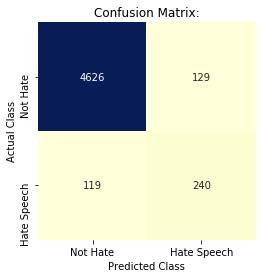

In [387]:
seaborn_confusion_matrix(y_val, lr_y_val_pred1)

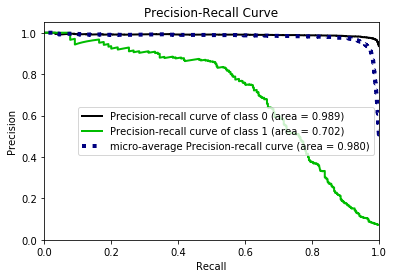

In [392]:
skplt.metrics.plot_precision_recall_curve(y_val, lr_y_val_prob1)

Adjusted Accuracy: 0.9579585451701212
Adjusted Precision: 0.7368421052631579
Adjusted Recall: 0.6239554317548747
Adjusted F1 Score: 0.6757164404223227




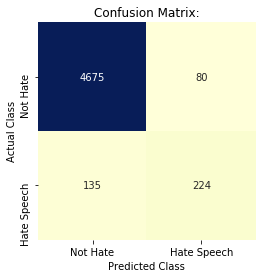

In [388]:
a, b = adjust_threshold_and_score(y_val, lr_y_val_prob1, .2)

### Final Test Performance for Logistic Regression:

In [485]:
logreg2, lr_X_test, lr_y_train_pred2, lr_y_test_pred, \
                lr_y_test_prob, logreg2_metrics, lr_pred_df2 = \
wrapper_single_vectorization(X_model.lem_tweet, y_model, X_test.lem_tweet,y_test, 
                             LogisticRegression(C = 9, penalty = 'l1', random_state = 10), 
                             count_vect, sampling= 'upsample')

In [486]:
logreg2_metrics

{'Train Accuracy': 1.0,
 'Train Precision': 1.0,
 'Train Recall': 1.0,
 'Train F1': 1.0,
 'Validation Accuracy': 0.95,
 'Validation Precision': 0.68,
 'Validation Recall': 0.67,
 'Validation F1': 0.67}

Adjusted Accuracy: 0.9583919912404192
Adjusted Precision: 0.7433155080213903
Adjusted Recall: 0.6205357142857143
Adjusted F1 Score: 0.6763990267639903




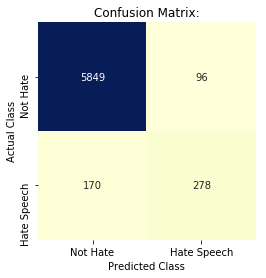

In [487]:
lr_test_adj, lr_cm = adjust_threshold_and_score (y_test, lr_y_test_prob, .2)

In [ ]:
# import eli5
# from eli5 import explain_weights, explain_prediction
# from eli5.formatters import format_as_html, format_as_text, format_html_styles, fields

In [ ]:
# eli5.show_weights(log, vec= count_vect, target_names= y_test, horizontal_layout=False)

In [ ]:
# skplt.metrics.plot_precision_recall_curve(y_test, lr_y_prob_test)

## SVM


### Initial Comparison of Multiple Vectorization and Class Imbalance Corrections:

In [83]:
#SVM with lemmatizing + no class balance corrections
svm_results1 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            SVC(gamma='auto', probability = True, random_state = 10), 
                            vectorization_list)
svm_results1 

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.93,0.93,0.93,0.93,0.93,0.93
Train F1,0.00,0.00,0.00,0.00,0.00,0.00
Train Precision,0.00,0.00,0.00,0.00,0.00,0.00
Train Recall,0.00,0.00,0.00,0.00,0.00,0.00
Validation Accuracy,0.93,0.93,0.93,0.93,0.93,0.93
Validation F1,0.00,0.00,0.00,0.00,0.00,0.00
Validation Precision,0.00,0.00,0.00,0.00,0.00,0.00
Validation Recall,0.00,0.00,0.00,0.00,0.00,0.00


In [84]:
# svm_results1.to_csv('data/SVM_results.csv',mode = 'a',header ='column_names')

In [85]:
#SVM with lemmatizing + class weight 'balanced' correction
svm_results2 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            SVC(gamma='auto', class_weight = 'balanced', probability = True, random_state = 10), 
                            vectorization_list)
svm_results2

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.07,0.07,0.07,0.07,0.07,0.07
Train F1,0.13,0.13,0.13,0.13,0.13,0.13
Train Precision,0.07,0.07,0.07,0.07,0.07,0.07
Train Recall,1.00,1.00,1.00,1.00,1.00,1.00
Validation Accuracy,0.07,0.07,0.07,0.07,0.07,0.07
Validation F1,0.13,0.13,0.13,0.13,0.13,0.13
Validation Precision,0.07,0.07,0.07,0.07,0.07,0.07
Validation Recall,1.00,1.00,1.00,1.00,1.00,1.00


In [86]:
# svm_results2.to_csv('data/SVM_results.csv', mode = 'a',header ='column_names')

In [87]:
svm_results3 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            SVC(gamma='auto', probability = True, random_state = 10), 
                            vectorization_list, sampling = 'upsample')
svm_results3 

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.66,0.66,0.66,0.62,0.53,0.53
Train F1,0.74,0.74,0.74,0.40,0.13,0.13
Train Precision,0.60,0.60,0.60,0.98,1.00,1.00
Train Recall,0.97,0.97,0.97,0.25,0.07,0.07
Validation Accuracy,0.39,0.39,0.39,0.94,0.93,0.93
Validation F1,0.18,0.18,0.18,0.35,0.11,0.11
Validation Precision,0.10,0.10,0.10,0.59,1.00,1.00
Validation Recall,0.97,0.97,0.97,0.25,0.06,0.06


In [88]:
# SVM with lemmatizing + downsampling
svm_results4 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            SVC(gamma= 'auto', probability = True, random_state = 10), 
                            vectorization_list, sampling = 'downsample')
svm_results4 

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.51,0.51,0.51,0.66,0.54,0.54
Train F1,0.67,0.67,0.67,0.50,0.16,0.16
Train Precision,0.51,0.51,0.51,0.97,1.00,1.00
Train Recall,1.00,1.00,1.00,0.34,0.09,0.09
Validation Accuracy,0.10,0.10,0.10,0.93,0.94,0.94
Validation F1,0.13,0.13,0.13,0.43,0.14,0.14
Validation Precision,0.07,0.07,0.07,0.48,1.00,1.00
Validation Recall,1.00,1.00,1.00,0.38,0.08,0.08


In [89]:
svm_results5 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            SVC(gamma='auto', probability = True, random_state = 10), 
                            vectorization_list, sampling = 'smote')
svm_results5 

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.18,0.18,0.18,0.94,0.94,0.94
Train F1,0.14,0.14,0.14,0.47,0.17,0.14
Train Precision,0.07,0.07,0.07,0.67,0.99,1.00
Train Recall,0.92,0.92,0.92,0.37,0.09,0.08
Validation Accuracy,0.19,0.19,0.19,0.94,0.94,0.93
Validation F1,0.14,0.14,0.14,0.47,0.15,0.13
Validation Precision,0.08,0.08,0.08,0.58,1.00,1.00
Validation Recall,0.93,0.93,0.93,0.40,0.08,0.07


### Randomized Search to optimize SVM Hyperparameters:

In [490]:
svc = SVC(random_state = 10, probability = True)

parameters = {
'C': [.001, .01, .1, .2, .3 , .4, .5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
'kernel':['linear', 'rbf'],
'gamma' :[0.1,0.8,1,1.2,1.4]}

scores = ['accuracy','recall','precision','f1']

svc_rs = RandomizedSearchCV(svc, param_distributions = parameters, scoring = scores, 
                                    cv = 3, refit = 'f1', return_train_score = True)

In [491]:
svc_1, svc_X_val1, svc_y_train_pred1, svc_y_val_pred1, \
                svc_y_val_prob1, svc_metrics1, svc_pred_df1 = \
wrapper_single_vectorization(X_train.lem_tweet, y_train, X_val.lem_tweet, y_val, 
                             svc_rs, tfidf_vect, sampling= 'smote')

In [492]:
svc_1.best_params_

{'kernel': 'rbf', 'gamma': 1.2, 'C': 10}

In [493]:
svc_metrics1

{'Train Accuracy': 1.0,
 'Train Precision': 1.0,
 'Train Recall': 1.0,
 'Train F1': 1.0,
 'Validation Accuracy': 0.96,
 'Validation Precision': 0.89,
 'Validation Recall': 0.49,
 'Validation F1': 0.63}

In [507]:
pd.DataFrame(svc_y_val_prob1).head()

,0,1
0,0.871222,0.128778
1,0.999864,0.000136
2,0.999523,0.000477
3,0.999979,0.000021
4,0.999964,0.000036


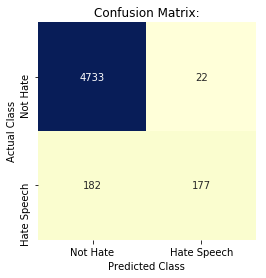

In [494]:
seaborn_confusion_matrix(y_val, svc_y_val_pred1)

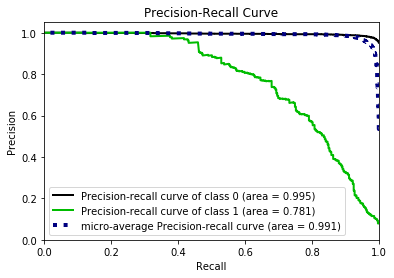

In [495]:
skplt.metrics.plot_precision_recall_curve(y_val, svc_y_val_prob1)

Adjusted Accuracy: 0.9565897536175205
Adjusted Precision: 0.6876712328767123
Adjusted Recall: 0.6991643454038997
Adjusted F1 Score: 0.6933701657458564




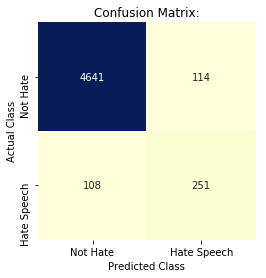

In [508]:
svc_adj_y, svc_cm1 = adjust_threshold_and_score(y_val, svc_y_val_prob1, .99)

### Final Test Performance for SVM:

In [514]:
svc_2, svc_X_test, svc_y_train_pred2, svc_y_test_pred, \
                svc_y_test_prob, svc_metrics2, svc_pred_df2 = \
wrapper_single_vectorization(X_model.lem_tweet, y_model, X_test.lem_tweet,y_test, 
                             SVC(kernel='rbf', gamma = 1.2, C = 10, probability = True), 
                             tfidf_vect, sampling= 'smote')

In [515]:
svc_metrics2

{'Train Accuracy': 1.0,
 'Train Precision': 1.0,
 'Train Recall': 1.0,
 'Train F1': 1.0,
 'Validation Accuracy': 0.96,
 'Validation Precision': 0.94,
 'Validation Recall': 0.51,
 'Validation F1': 0.66}

Adjusted Accuracy: 0.9652745190051619
Adjusted Precision: 0.7511111111111111
Adjusted Recall: 0.7544642857142857
Adjusted F1 Score: 0.7527839643652561




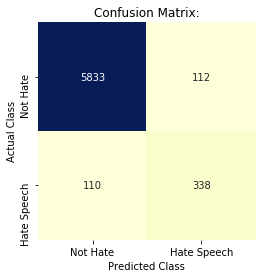

In [516]:
svc_y_test_adj, sv_cm = adjust_threshold_and_score (y_test, svc_y_test_prob, .99)

# Random Forest

### Comparing Classifier Performance with Multiple Vectorizer Methods and Class Imbalance Corrections

In [90]:
#Random Forest: compare vectorizers with lemmatizing; no explicit class balance corrections
rfc_results1 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            RandomForestClassifier(random_state=10), vectorization_list)
rfc_results1

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.99,0.99,0.99,0.99,0.99,0.99
Train F1,0.95,0.95,0.95,0.95,0.93,0.94
Train Precision,1.00,1.00,1.00,1.00,1.00,1.00
Train Recall,0.91,0.91,0.91,0.91,0.88,0.88
Validation Accuracy,0.96,0.96,0.96,0.96,0.96,0.96
Validation F1,0.61,0.61,0.61,0.62,0.58,0.57
Validation Precision,0.93,0.93,0.93,0.88,0.95,0.95
Validation Recall,0.45,0.45,0.45,0.48,0.42,0.40


In [91]:
# rfc_results1.to_csv('data/RFC_results.csv',mode = 'a',header ='column_names')

In [92]:
#Random Forest: compare vectorizers with lemmatizing and class weights balanced
rfc_results2 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            RandomForestClassifier(random_state=10, class_weight = 'balanced'), 
                            vectorization_list)
rfc_results2

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.99,0.99,0.99,0.99,0.99,0.99
Train F1,0.95,0.95,0.95,0.94,0.94,0.93
Train Precision,1.00,1.00,1.00,1.00,1.00,1.00
Train Recall,0.91,0.91,0.91,0.89,0.88,0.88
Validation Accuracy,0.96,0.96,0.96,0.95,0.95,0.95
Validation F1,0.54,0.54,0.54,0.51,0.50,0.49
Validation Precision,0.98,0.98,0.98,0.93,0.95,0.95
Validation Recall,0.37,0.37,0.37,0.35,0.34,0.33


In [93]:
# rfc_results2.to_csv('data/RFC_results.csv',mode = 'a',header ='column_names')

In [95]:
#Random Forest: compare vectorizers with lemmatizing and upsampling
rfc_results3 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            RandomForestClassifier(random_state=10), 
                            vectorization_list, sampling = 'upsample')
rfc_results3

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,1.00,1.00,1.00,1.00,1.00,1.00
Train F1,1.00,1.00,1.00,1.00,1.00,1.00
Train Precision,1.00,1.00,1.00,1.00,1.00,1.00
Train Recall,1.00,1.00,1.00,1.00,1.00,1.00
Validation Accuracy,0.96,0.96,0.96,0.96,0.96,0.95
Validation F1,0.59,0.59,0.59,0.59,0.56,0.54
Validation Precision,0.93,0.93,0.93,0.92,0.92,0.89
Validation Recall,0.43,0.43,0.43,0.43,0.41,0.39


In [96]:
# rfc_results3.to_csv('data/RFC_results.csv',mode = 'a',header ='column_names')

In [97]:
#Random Forest: compare vectorizers with lemmatizing and downsampling
rfc_results4 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            RandomForestClassifier(random_state=10), 
                            vectorization_list, sampling = 'downsample')
rfc_results4

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.99,0.99,0.99,0.99,0.99,0.99
Train F1,0.99,0.99,0.99,0.99,0.98,0.99
Train Precision,1.00,1.00,1.00,1.00,1.00,1.00
Train Recall,0.98,0.98,0.98,0.98,0.97,0.98
Validation Accuracy,0.86,0.86,0.86,0.83,0.85,0.84
Validation F1,0.42,0.42,0.42,0.38,0.40,0.38
Validation Precision,0.30,0.30,0.30,0.26,0.28,0.26
Validation Recall,0.73,0.73,0.73,0.77,0.70,0.70


In [98]:
# rfc_results4.to_csv('data/RFC_results.csv',mode = 'a',header ='column_names')

In [99]:
#Random Forest: compare vectorizers with lemmatizing and smote
rfc_results5 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            RandomForestClassifier(random_state=10), 
                            vectorization_list, sampling = 'smote', sample_class = 'not majority')
rfc_results5

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.99,0.99,0.99,1.00,1.00,1.00
Train F1,0.96,0.96,0.96,1.00,0.99,0.99
Train Precision,0.95,0.95,0.95,1.00,1.00,1.00
Train Recall,0.96,0.96,0.96,0.99,0.99,0.99
Validation Accuracy,0.89,0.89,0.89,0.95,0.95,0.95
Validation F1,0.42,0.42,0.42,0.55,0.53,0.52
Validation Precision,0.34,0.34,0.34,0.87,0.97,0.92
Validation Recall,0.55,0.55,0.55,0.40,0.37,0.36


In [ ]:
# rfc_results5.to_csv('data/RFC_results.csv',mode = 'a',header ='column_names')

### Hypertuning Random Forest Hyperparameters: TFIDF Vectorizer and Upsampling

In [549]:
np.random.seed(0)
rfc = RandomForestClassifier(random_state=10)

parameters = {'n_estimators' : [40, 60, 80, 100, 120],
'max_leaf_nodes' : [100, 200, 300, 400],
'random_state' : [10],
'max_depth': [5, 6, 7, 8, 10, 20, 25, 30],
 'verbose' : [0]}
# 'class_weight': [{0:5, 1:5}, {0:2, 1:8}, {0:4, 1:6}, {0:6, 1: 4}, {0:8, 1:2}]}
#'class_weight': ['balanced', 'balanced_subsample']}

scores = ['accuracy','recall','precision','f1']

rfc_gs = GridSearchCV(rfc, param_grid = parameters, scoring = scores, cv = 3, refit = 'f1')

In [550]:
rfc_1, rfc_X_val1, rfc_y_train_pred1, rfc_y_val_pred1, \
                rfc_y_val_prob1, rfc_metrics1, rfc_pred_df1 = \
wrapper_single_vectorization(X_train.lem_tweet, y_train, X_val.lem_tweet, 
                y_val, rfc_gs, count_vect, sampling = 'upsample')

In [551]:
rfc_1.best_params_

{'max_depth': 30,
 'max_leaf_nodes': 400,
 'n_estimators': 120,
 'random_state': 10,
 'verbose': 0}

In [552]:
rfc_df = pd.DataFrame(rfc_1.cv_results_)
rfc_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_n_estimators,param_random_state,param_verbose,params,...,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,1.342050,0.019058,0.276361,0.009702,5,100,40,10,0,"{'max_depth': 5, 'max_leaf_nodes': 100, 'n_est...",...,0.855165,0.835528,0.018032,153,0.771941,0.757319,0.740429,0.756563,0.012876,157
1,1.979778,0.008674,0.367261,0.022128,5,100,60,10,0,"{'max_depth': 5, 'max_leaf_nodes': 100, 'n_est...",...,0.850493,0.850312,0.012611,145,0.795773,0.779820,0.788458,0.788017,0.006521,145
2,2.758548,0.114435,0.511189,0.008152,5,100,80,10,0,"{'max_depth': 5, 'max_leaf_nodes': 100, 'n_est...",...,0.855303,0.851867,0.006506,141,0.800166,0.786507,0.807362,0.798012,0.008649,133
3,3.272102,0.153780,0.617263,0.024429,5,100,100,10,0,"{'max_depth': 5, 'max_leaf_nodes': 100, 'n_est...",...,0.860975,0.854870,0.005556,129,0.805365,0.794590,0.815510,0.805155,0.008542,125
4,3.801093,0.039568,0.666346,0.022354,5,100,120,10,0,"{'max_depth': 5, 'max_leaf_nodes': 100, 'n_est...",...,0.864014,0.867604,0.003893,109,0.811201,0.813910,0.824092,0.816401,0.005550,101


In [553]:
rfc_1.best_score_

0.9001530511760639

In [554]:
rfc_metrics1

{'Train Accuracy': 0.92,
 'Train Precision': 0.97,
 'Train Recall': 0.86,
 'Train F1': 0.91,
 'Validation Accuracy': 0.93,
 'Validation Precision': 0.48,
 'Validation Recall': 0.67,
 'Validation F1': 0.56}

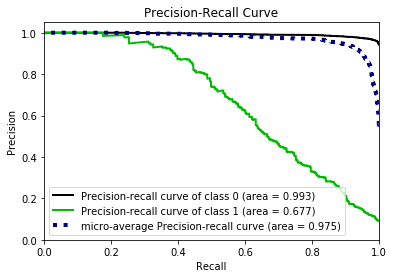

In [555]:
skplt.metrics.plot_precision_recall_curve(y_val, rfc_y_val_prob1)

Adjusted Accuracy: 0.95267892061009
Adjusted Precision: 0.7191011235955056
Adjusted Recall: 0.5348189415041783
Adjusted F1 Score: 0.6134185303514378




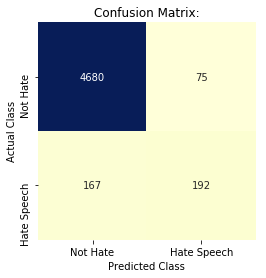

In [556]:
rfc_y_val_adj, rfc_cm1 = adjust_threshold_and_score(y_val, rfc_y_val_prob1, .47)

###  Final Random Forest Model: Test Performance

In [557]:
rfc = RandomForestClassifier(n_estimators = 120, max_leaf_nodes = 400, 
                       max_depth = 30, random_state = 10, verbose = 0)

In [558]:
rfc_2, rfc_X_test, rfc_y_train_pred2, rfc_y_test_pred2, \
                rfc_y_test_prob2, rfc_metrics2, rfc_pred_df2 = \
wrapper_single_vectorization(X_model.lem_tweet, y_model, X_test.lem_tweet, 
                y_test, rfc, count_vect, sampling = 'upsample')

In [559]:
rfc_metrics2

{'Train Accuracy': 0.92,
 'Train Precision': 0.96,
 'Train Recall': 0.87,
 'Train F1': 0.91,
 'Validation Accuracy': 0.94,
 'Validation Precision': 0.54,
 'Validation Recall': 0.75,
 'Validation F1': 0.63}

Adjusted Accuracy: 0.9596433599249179
Adjusted Precision: 0.7932098765432098
Adjusted Recall: 0.5736607142857143
Adjusted F1 Score: 0.6658031088082902




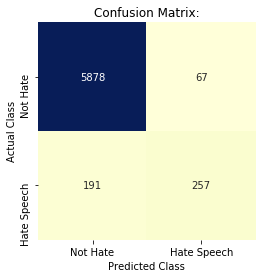

In [560]:
rfc_adj_y_test2, cm2 = adjust_threshold_and_score(y_test, rfc_y_test_prob2, .47)

# AdaBoost

### Comparison Across Multiple Vectorization and Class Imbalance Correction Methods

In [100]:
#AdaBoost with Decision Tree, lemmatizing + no class balance corrections
ab_results1 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                           AdaBoostClassifier(random_state =10), vectorization_list)
ab_results1

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.95,0.95,0.95,0.95,0.95,0.95
Train F1,0.47,0.47,0.47,0.47,0.46,0.45
Train Precision,0.75,0.75,0.75,0.73,0.76,0.77
Train Recall,0.34,0.34,0.34,0.35,0.33,0.32
Validation Accuracy,0.95,0.95,0.95,0.94,0.94,0.94
Validation F1,0.46,0.46,0.46,0.47,0.44,0.45
Validation Precision,0.77,0.77,0.77,0.72,0.74,0.72
Validation Recall,0.33,0.33,0.33,0.34,0.32,0.33


In [101]:
#AdaBoost with Decision Tree, lemmatizing + class balance corrections
dct = DecisionTreeClassifier(class_weight = 'balanced')
ab_results2 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                           AdaBoostClassifier(base_estimator = dct, random_state = 10), vectorization_list)
ab_results2

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,1.00,1.00,1.00,1.00,1.00,1.00
Train F1,1.00,1.00,1.00,1.00,1.00,1.00
Train Precision,1.00,1.00,1.00,1.00,1.00,1.00
Train Recall,1.00,1.00,1.00,1.00,1.00,1.00
Validation Accuracy,0.92,0.92,0.92,0.91,0.92,0.92
Validation F1,0.53,0.53,0.53,0.49,0.51,0.50
Validation Precision,0.44,0.44,0.44,0.41,0.46,0.45
Validation Recall,0.67,0.67,0.67,0.60,0.57,0.56


In [102]:
#AdaBoost with Decision Tree, lemmatizing + upsampling
ab_results3 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                           AdaBoostClassifier(random_state =10), vectorization_list, sampling = 'upsample')
ab_results3

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.77,0.77,0.77,0.79,0.81,0.81
Train F1,0.74,0.74,0.74,0.77,0.80,0.80
Train Precision,0.86,0.86,0.86,0.83,0.85,0.85
Train Recall,0.65,0.65,0.65,0.72,0.77,0.76
Validation Accuracy,0.88,0.88,0.88,0.81,0.77,0.73
Validation F1,0.43,0.43,0.43,0.35,0.32,0.29
Validation Precision,0.32,0.32,0.32,0.23,0.20,0.18
Validation Recall,0.65,0.65,0.65,0.70,0.79,0.79


In [103]:
#AdaBoost with Decision Tree, lemmatizing + downsampling
ab_results4 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                           AdaBoostClassifier(random_state =10), vectorization_list, sampling = 'downsample')
ab_results4

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.78,0.78,0.78,0.79,0.78,0.79
Train F1,0.76,0.76,0.76,0.77,0.76,0.76
Train Precision,0.83,0.83,0.83,0.86,0.84,0.87
Train Recall,0.70,0.70,0.70,0.70,0.70,0.68
Validation Accuracy,0.82,0.82,0.82,0.82,0.80,0.83
Validation F1,0.35,0.35,0.35,0.34,0.32,0.35
Validation Precision,0.24,0.24,0.24,0.23,0.21,0.24
Validation Recall,0.69,0.69,0.69,0.67,0.67,0.65


In [104]:
#AdaBoost with Decision Tree, lemmatizing + smote
ab_results5 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                           AdaBoostClassifier(random_state =10), vectorization_list, sampling = 'smote')
ab_results5

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.73,0.73,0.73,0.91,0.90,0.91
Train F1,0.26,0.26,0.26,0.45,0.44,0.45
Train Precision,0.16,0.16,0.16,0.38,0.38,0.38
Train Recall,0.68,0.68,0.68,0.55,0.54,0.55
Validation Accuracy,0.72,0.72,0.72,0.91,0.90,0.91
Validation F1,0.26,0.26,0.26,0.45,0.44,0.45
Validation Precision,0.16,0.16,0.16,0.39,0.37,0.38
Validation Recall,0.71,0.71,0.71,0.54,0.53,0.54


### Grid Searching for Best Hyperparameters using Count Vectorizer and balanced class weights

## XGBooster

In [105]:
xgb_results1 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            XGBClassifier(random_state =10), vectorization_list)
xgb_results1

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.94,0.94,0.94,0.94,0.94,0.94
Train F1,0.34,0.34,0.34,0.36,0.34,0.35
Train Precision,0.93,0.93,0.93,0.94,0.95,0.96
Train Recall,0.21,0.21,0.21,0.22,0.21,0.22
Validation Accuracy,0.94,0.94,0.94,0.94,0.94,0.94
Validation F1,0.34,0.34,0.34,0.35,0.34,0.34
Validation Precision,0.92,0.92,0.92,0.92,0.91,0.93
Validation Recall,0.21,0.21,0.21,0.22,0.21,0.21


In [106]:
#XGB with scale and min child weight set to 1 to correct for class imbalance
xgb_results2 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            XGBClassifier(scale_pos_weight = 1, min_child_weight = 1,
                            random_state =10), vectorization_list)
xgb_results2

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.94,0.94,0.94,0.94,0.94,0.94
Train F1,0.34,0.34,0.34,0.36,0.34,0.35
Train Precision,0.93,0.93,0.93,0.94,0.95,0.96
Train Recall,0.21,0.21,0.21,0.22,0.21,0.22
Validation Accuracy,0.94,0.94,0.94,0.94,0.94,0.94
Validation F1,0.34,0.34,0.34,0.35,0.34,0.34
Validation Precision,0.92,0.92,0.92,0.92,0.91,0.93
Validation Recall,0.21,0.21,0.21,0.22,0.21,0.21


In [107]:
xgb_results3 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            XGBClassifier(random_state =10), vectorization_list, sampling = 'upsample')
xgb_results3

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.81,0.81,0.81,0.81,0.83,0.83
Train F1,0.79,0.79,0.79,0.79,0.82,0.83
Train Precision,0.87,0.87,0.87,0.87,0.87,0.88
Train Recall,0.72,0.72,0.72,0.73,0.77,0.78
Validation Accuracy,0.87,0.87,0.87,0.85,0.78,0.74
Validation F1,0.43,0.43,0.43,0.38,0.32,0.30
Validation Precision,0.31,0.31,0.31,0.27,0.20,0.19
Validation Recall,0.67,0.67,0.67,0.67,0.76,0.79


In [108]:
xgb_results4 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            XGBClassifier(random_state =10), vectorization_list, sampling = 'downsample')
xgb_results4

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.79,0.79,0.79,0.80,0.81,0.81
Train F1,0.78,0.78,0.78,0.78,0.79,0.80
Train Precision,0.86,0.86,0.86,0.87,0.87,0.86
Train Recall,0.71,0.71,0.71,0.71,0.72,0.74
Validation Accuracy,0.83,0.83,0.83,0.82,0.83,0.83
Validation F1,0.37,0.37,0.37,0.34,0.36,0.37
Validation Precision,0.25,0.25,0.25,0.23,0.24,0.25
Validation Recall,0.70,0.70,0.70,0.69,0.69,0.70


In [109]:
xgb_results5 = wrapper_compare_vectorizations(X_train.lem_tweet, 
                            y_train, X_val.lem_tweet, y_val, 
                            XGBClassifier(random_state =10), vectorization_list, sampling = 'smote')
xgb_results5

,COUNT_VECTORIZER,COUNT_NGRAM_1_2,COUNT_NGRAM_1_3,TFIDF_VECTORIZER,TFIDF_NGRAM_1_2,TFIDF_NGRAM_1_3
Train Accuracy,0.94,0.94,0.94,0.94,0.94,0.94
Train F1,0.38,0.38,0.38,0.45,0.45,0.44
Train Precision,0.77,0.77,0.77,0.62,0.64,0.66
Train Recall,0.25,0.25,0.25,0.35,0.34,0.33
Validation Accuracy,0.94,0.94,0.94,0.94,0.94,0.94
Validation F1,0.35,0.35,0.35,0.46,0.45,0.43
Validation Precision,0.70,0.70,0.70,0.64,0.68,0.71
Validation Recall,0.23,0.23,0.23,0.36,0.33,0.31


# Word to Vec: Training Model and Testing Classifiers 

### X-train pre-processing

In [110]:
X_train_token_list = list(X_train.tokenized_tweet)

In [111]:
X_train_token_sumlist = sum(X_train_token_list,[])
X_train_unique_tokens = set(X_train_token_sumlist)
print('The unique number of words in the training dataset is: {}'.format(len(X_train_unique_tokens)))

The unique number of words in the training dataset is: 28682


#### X-val pre-processing

In [112]:
X_val_token_list = list(X_val['tokenized_tweet'])

In [113]:
X_val_token_sumlist = sum(X_val_token_list,[])
X_val_unique_tokens = set(X_val_token_sumlist)

print('The unique number of words in the validation dataset is: {}'.format(len(X_val_unique_tokens)))

The unique number of words in the validation dataset is: 11761


#### X-test pre-processing

In [114]:
X_test_token_list = list(X_test['tokenized_tweet'])

In [115]:
X_test_token_sumlist = sum(X_test_token_list,[])

X_test_unique_tokens = set(X_test_token_sumlist)
print('The unique number of words in the training dataset is: {}'.format(len(X_test_unique_tokens)))

The unique number of words in the training dataset is: 13677


### Training Word2Vec Model - 100D, 200D, 300D

In [ ]:
from time import time
t = time()

w2v_model100 = gensim.models.Word2Vec(X_train_token_list, sg=1, min_count=1, size = 100)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
w2v_model100.train(X_train_token_list, total_examples=w2v_model100.corpus_count, epochs=w2v_model100.epochs)

In [ ]:
w2v_model100.save('data/w2v100.model')
w2v_model100 = gensim.models.Word2Vec.load('data/w2v100.model')

In [ ]:
#create average vector for train and test from model; return list of numpy arrays are then stacked 

X_train_w2v100 = np.concatenate([avg_word_vectors(sentence, w2v_model100, 100) for sentence in X_train_token_list])
X_val_w2v100 = np.concatenate([avg_word_vectors(sentence, w2v_model100, 100) for sentence in X_val_token_list])

with open('data/mean_w2v_vectors.pkl', 'wb') as f:
	pickle.dump([X_train_w2v100, X_val_w2v100], f)

In [ ]:
## W2V 200 dimension model:

In [ ]:
w2v_model200 = gensim.models.Word2Vec(X_train_token_list, sg=1, min_count=1, size = 200)

In [ ]:
w2v_model200.train(X_train_token_list, total_examples=w2v_model200.corpus_count, epochs=w2v_model200.epochs)

In [ ]:
w2v_model200.save('data/w2v_200d.model')
w2v_model200 = gensim.models.Word2Vec.load('data/w2v_200d.model')

In [ ]:
#create average vector for train and test from model; return list of numpy arrays are then stacked
X_train_w2v200 = np.concatenate([avg_word_vectors(sentence, w2v_model200, 200) for sentence in X_train_token_list])
X_val_w2v200 = np.concatenate([avg_word_vectors(sentence, w2v_model200, 200) for sentence in X_val_token_list])

In [ ]:
with open('data/mean_w2v_vectors200.pkl', 'wb') as f:
	pickle.dump([X_train_w2v200, X_val_w2v200], f)

In [ ]:
## W2V 300 dimension model:

In [ ]:
w2v_model300 = gensim.models.Word2Vec(X_train_token_list, sg=1, min_count=1, size = 300)

In [ ]:
w2v_model300.train(X_train_token_list, total_examples=w2v_model300.corpus_count, epochs=w2v_model300.epochs)

In [ ]:
w2v_model300.save('data/w2v_300d.model')
w2v_model300 = gensim.models.Word2Vec.load('data/w2v_300d.model')

In [ ]:
#create average vector for train and test from model; return list of numpy arrays are then stacked 

X_train_w2v300 = np.concatenate([avg_word_vectors(sentence, w2v_model300, 300) for sentence in X_train_token_list])
X_val_w2v300 = np.concatenate([avg_word_vectors(sentence, w2v_model300, 300) for sentence in X_val_token_list])

with open('data/mean_w2v_vectors300.pkl', 'wb') as f:
	pickle.dump([X_train_w2v300, X_val_w2v300], f)

## Classification with Trained Word2Vec Embeddings - 100D

In [116]:
with open('data/mean_w2v_vectors.pkl', 'rb') as f:
    X_train_w2v100, X_val_w2v100 = pickle.load(f)

In [117]:
classifier_list = [('LogisticRegression', LogisticRegression(random_state = 10)),
                   ('SVM', SVC(gamma='auto', probability = True, random_state = 10)),
                    ('RandomForest', RandomForestClassifier(random_state = 10)),
                    ('AdaBoost', AdaBoostClassifier(random_state=10)),
                    ('XGBooster', XGBClassifier(random_state=10))]

In [118]:
w2v_model_results1 = mean_embedding_compare_classification(X_train_w2v100, y_train, X_val_w2v100, y_val, classifier_list)
w2v_model_results1

,LogisticRegression,SVM,RandomForest,AdaBoost,XGBooster
Train Accuracy,0.94,0.93,0.99,0.94,0.95
Train F1,0.36,0.06,0.94,0.45,0.49
Train Precision,0.72,1.00,1.00,0.66,0.80
Train Recall,0.24,0.03,0.90,0.35,0.35
Validation Accuracy,0.94,0.93,0.95,0.94,0.94
Validation F1,0.35,0.05,0.46,0.41,0.41
Validation Precision,0.68,1.00,0.86,0.62,0.71
Validation Recall,0.24,0.03,0.32,0.31,0.28


In [119]:
w2v_model_results5 = mean_embedding_compare_classification(X_train_w2v100, y_train, X_val_w2v100, y_val, 
                                                           classifier_list, sampling = 'smote')
w2v_model_results5

,LogisticRegression,SVM,RandomForest,AdaBoost,XGBooster
Train Accuracy,0.84,0.81,1.00,0.84,0.87
Train F1,0.42,0.40,0.99,0.42,0.49
Train Precision,0.28,0.26,0.99,0.28,0.34
Train Recall,0.85,0.87,1.00,0.81,0.87
Validation Accuracy,0.85,0.83,0.94,0.85,0.88
Validation F1,0.44,0.41,0.55,0.42,0.47
Validation Precision,0.30,0.27,0.57,0.29,0.34
Validation Recall,0.84,0.85,0.53,0.76,0.78


##### upsampling and downsampling - XGBoost not included

In [58]:
classifier_list2 = [('LogisticRegression', LogisticRegression(random_state = 10)),
                   ('SVM', SVC(gamma='auto', probability = True, random_state = 10)),
                    ('RandomForest', RandomForestClassifier(random_state = 10)),
                    ('AdaBoost', AdaBoostClassifier(random_state=10))]

In [562]:
w2v_model_results3 = mean_embedding_compare_classification(X_train_w2v100, y_train, X_val_w2v100, y_val, classifier_list2, 
                                      sampling = 'upsample')
w2v_model_results3

,LogisticRegression,SVM,RandomForest,AdaBoost
Train Accuracy,0.57,0.55,0.98,0.65
Train F1,0.57,0.57,0.98,0.66
Train Precision,0.57,0.55,0.97,0.64
Train Recall,0.57,0.58,1.00,0.69
Validation Accuracy,0.54,0.48,0.91,0.57
Validation F1,0.10,0.11,0.10,0.10
Validation Precision,0.06,0.06,0.16,0.06
Validation Recall,0.36,0.45,0.07,0.35


In [563]:
w2v_model_results4 = mean_embedding_compare_classification(X_train_w2v100, y_train, X_val_w2v100, y_val, classifier_list2, 
                                      sampling = 'downsample')
w2v_model_results4

,LogisticRegression,SVM,RandomForest,AdaBoost
Train Accuracy,0.59,0.55,0.98,0.76
Train F1,0.59,0.35,0.98,0.76
Train Precision,0.59,0.64,1.00,0.77
Train Recall,0.58,0.24,0.97,0.74
Validation Accuracy,0.50,0.75,0.35,0.38
Validation F1,0.14,0.04,0.12,0.13
Validation Precision,0.08,0.03,0.07,0.07
Validation Recall,0.57,0.08,0.66,0.64


## Classification with w2v Embeddings - 300D:

In [122]:
with open('data/mean_w2v_vectors.pkl', 'rb') as f:
    X_train_w2v300, X_val_w2v300 = pickle.load(f)

In [123]:
w2v300_model_results1 = mean_embedding_compare_classification(X_train_w2v300, y_train, 
                                                              X_val_w2v300, y_val, classifier_list)
w2v300_model_results1

,LogisticRegression,SVM,RandomForest,AdaBoost,XGBooster
Train Accuracy,0.94,0.93,0.99,0.94,0.95
Train F1,0.36,0.06,0.94,0.45,0.49
Train Precision,0.72,1.00,1.00,0.66,0.80
Train Recall,0.24,0.03,0.90,0.35,0.35
Validation Accuracy,0.94,0.93,0.95,0.94,0.94
Validation F1,0.35,0.05,0.46,0.41,0.41
Validation Precision,0.68,1.00,0.86,0.62,0.71
Validation Recall,0.24,0.03,0.32,0.31,0.28


In [124]:
w2v300_model_results5 = mean_embedding_compare_classification(X_train_w2v300, y_train, X_val_w2v300, y_val, classifier_list, 
                                      sampling = 'smote')

w2v300_model_results5

,LogisticRegression,SVM,RandomForest,AdaBoost,XGBooster
Train Accuracy,0.84,0.81,1.00,0.84,0.87
Train F1,0.42,0.40,0.99,0.42,0.49
Train Precision,0.28,0.26,0.99,0.28,0.34
Train Recall,0.85,0.87,1.00,0.81,0.87
Validation Accuracy,0.85,0.83,0.94,0.85,0.88
Validation F1,0.44,0.41,0.55,0.42,0.47
Validation Precision,0.30,0.27,0.57,0.29,0.34
Validation Recall,0.84,0.85,0.53,0.76,0.78


In [564]:
w2v_model_results3 = mean_embedding_compare_classification(X_train_w2v300, y_train, X_val_w2v300, y_val, classifier_list2, 
                                      sampling = 'upsample')
w2v_model_results3

,LogisticRegression,SVM,RandomForest,AdaBoost
Train Accuracy,0.57,0.55,0.98,0.65
Train F1,0.57,0.57,0.98,0.66
Train Precision,0.57,0.55,0.97,0.64
Train Recall,0.57,0.58,1.00,0.69
Validation Accuracy,0.54,0.48,0.91,0.57
Validation F1,0.10,0.11,0.10,0.10
Validation Precision,0.06,0.06,0.16,0.06
Validation Recall,0.36,0.45,0.07,0.35


In [565]:
w2v_model_results4 = mean_embedding_compare_classification(X_train_w2v300, y_train, X_val_w2v300, y_val, classifier_list2, 
                                      sampling = 'downsample')
w2v_model_results4

,LogisticRegression,SVM,RandomForest,AdaBoost
Train Accuracy,0.59,0.55,0.98,0.76
Train F1,0.59,0.35,0.98,0.76
Train Precision,0.59,0.64,1.00,0.77
Train Recall,0.58,0.24,0.97,0.74
Validation Accuracy,0.50,0.75,0.35,0.38
Validation F1,0.14,0.04,0.12,0.13
Validation Precision,0.08,0.03,0.07,0.07
Validation Recall,0.57,0.08,0.66,0.64


#  GLoVe: Transfer Learning with Pre-Trained Word Embeddings

## Preparing Mean Word Embeddings

In [ ]:
#Glove Twitter databse with 100 dimensions

In [ ]:
glove_input_file = 'data/glove.twitter.27B.100d.txt'
glove_output_file = 'data/glove100.txt.word2vec'
glove2word2vec(glove_input_file, glove_output_file)

In [ ]:
glove100_model = KeyedVectors.load_word2vec_format('data/glove.txt.word2vec', binary=False)

In [ ]:
X_train_glove100 = np.concatenate([avg_word_vectors(sentence, glove_model, 100) for sentence in X_train_token_list])
X_val_glove100 = np.concatenate([avg_word_vectors(sentence, glove_model, 100) for sentence in X_val_token_list])

In [ ]:
with open('data/mean_glove_vectors100.pkl', 'wb') as f:
	pickle.dump([X_train_glove100, X_val_glove100], f)

In [ ]:
#Glove Twitter databse with 200 dimensions

In [ ]:
glove_input_file = 'data/glove.twitter.27B.200d.txt'
glove_output_file = 'data/glove200.txt.word2vec'
glove2word2vec(glove_input_file, glove_output_file)

In [ ]:
glove200_model = KeyedVectors.load_word2vec_format('data/glove200.txt.word2vec', binary=False)

In [ ]:
X_train_glove200 = np.concatenate([avg_word_vectors(sentence, glove200_model, 200) for sentence in X_train_token_list])
X_val_glove200 = np.concatenate([avg_word_vectors(sentence, glove200_model, 200) for sentence in X_val_token_list])

In [ ]:
with open('data/mean_glove_vectors200.pkl', 'wb') as f:
	pickle.dump([X_train_glove200, X_val_glove200], f)

## Classification with GLoVe 100 dimensions:

In [63]:
with open('data/mean_glove_vectors100.pkl', 'rb') as f:
    X_train_glove100, X_val_glove100 = pickle.load(f)

In [126]:
glove100_results1 = mean_embedding_compare_classification(X_train_glove100, y_train, X_val_glove100, 
                                                          y_val, classifier_list)
glove100_results1

,LogisticRegression,SVM,RandomForest,AdaBoost,XGBooster
Train Accuracy,0.94,0.93,0.99,0.94,0.95
Train F1,0.44,0.04,0.94,0.48,0.52
Train Precision,0.68,0.94,1.00,0.64,0.81
Train Recall,0.33,0.02,0.89,0.38,0.38
Validation Accuracy,0.94,0.93,0.94,0.94,0.94
Validation F1,0.41,0.03,0.42,0.45,0.44
Validation Precision,0.65,1.00,0.79,0.57,0.72
Validation Recall,0.30,0.02,0.29,0.36,0.32


In [127]:
glove100_results5 = mean_embedding_compare_classification(X_train_glove100, y_train, X_val_glove100, 
                                                          y_val, classifier_list, sampling = 'smote')
glove100_results5

,LogisticRegression,SVM,RandomForest,AdaBoost,XGBooster
Train Accuracy,0.86,0.86,1.00,0.86,0.89
Train F1,0.47,0.47,0.99,0.44,0.53
Train Precision,0.32,0.32,0.99,0.31,0.39
Train Recall,0.86,0.86,1.00,0.79,0.87
Validation Accuracy,0.86,0.86,0.94,0.85,0.88
Validation F1,0.45,0.46,0.56,0.41,0.48
Validation Precision,0.31,0.32,0.57,0.28,0.35
Validation Recall,0.82,0.83,0.56,0.75,0.79


In [64]:
glove100_results3 = mean_embedding_compare_classification(X_train_glove100, y_train, X_val_glove100, y_val, 
                                                           classifier_list2, sampling = 'upsample')

In [68]:
glove100_results4 = mean_embedding_compare_classification(X_train_glove100, y_train, X_val_glove100, y_val, 
                                                           classifier_list2, sampling = 'downsample')

## Classification with GLoVe 200 dimensions:

In [53]:
with open('data/mean_glove_vectors200.pkl', 'rb') as f:
    X_train_glove200, X_val_glove200 = pickle.load(f)

In [54]:
glove200_results1 = mean_embedding_compare_classification(X_train_glove200, y_train, X_val_glove200, 
                                                          y_val, classifier_list)
glove200_results1

,LogisticRegression,RandomForest,AdaBoost,XGBooster
Train Accuracy,0.95,0.99,0.94,0.95
Train F1,0.49,0.94,0.50,0.54
Train Precision,0.72,1.00,0.64,0.84
Train Recall,0.37,0.89,0.41,0.40
Validation Accuracy,0.94,0.94,0.94,0.95
Validation F1,0.47,0.39,0.48,0.46
Validation Precision,0.69,0.83,0.61,0.74
Validation Recall,0.35,0.26,0.40,0.34


In [55]:
glove200_results5 = mean_embedding_compare_classification(X_train_glove200, y_train, X_val_glove200, 
                                                          y_val, classifier_list, sampling = 'smote')
glove200_results5

,LogisticRegression,RandomForest,AdaBoost,XGBooster
Train Accuracy,0.88,1.00,0.86,0.90
Train F1,0.50,1.00,0.44,0.55
Train Precision,0.35,0.99,0.31,0.40
Train Recall,0.86,1.00,0.78,0.86
Validation Accuracy,0.88,0.93,0.85,0.88
Validation F1,0.48,0.50,0.40,0.47
Validation Precision,0.34,0.52,0.28,0.34
Validation Recall,0.82,0.49,0.71,0.77


In [69]:
glove200_results3 = mean_embedding_compare_classification(X_train_glove200, y_train, X_val_glove200, y_val, 
                                                           classifier_list2, sampling = 'upsample')

In [70]:
glove200_results4 = mean_embedding_compare_classification(X_train_glove200, y_train, X_val_glove200, y_val, 
                                                           classifier_list2, sampling = 'downsample')